## Sentiment Analysis using Convolutional Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
train = pd.read_csv('labeledTrainData.tsv',quoting=3,header=0,delimiter='\t')
test = pd.read_csv('testData.tsv',quoting=3,header=0,delimiter='\t')
all_data = pd.read_csv('unlabeledTrainData.tsv',quoting=3,header=0,delimiter='\t')

In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
train.review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [5]:
def clean_review(movie_review):
    #Remove HTML tags
    review = BeautifulSoup(movie_review,"lxml").get_text()
    
    #Remove non-alphabets
    review = re.sub("[^a-zA-Z]"," ",review)
    return review.lower().split()

In [6]:
trainReview = [clean_review(review) for review in train.review]
testReview = [clean_review(review) for review in test.review]
all_dataReview = [clean_review(review) for review in all_data.review]

In [7]:
vocab = trainReview + all_dataReview

### Word2Vec Vectorizer with size=32

In [8]:
from gensim.models import Word2Vec
vec = Word2Vec(size=32, window=8, min_count=10)
vec.build_vocab(vocab)

In [23]:
vec.train(vocab[::1])
vec.save('word2vec32.w2v')

In [18]:
vec = Word2Vec.load('word2vec32.w2v')

In [24]:
vec.most_similar('happy')

[(u'afraid', 0.7534735798835754),
 (u'lucky', 0.7092074751853943),
 (u'enjoying', 0.7065383195877075),
 (u'excited', 0.6953328847885132),
 (u'satisfied', 0.6941491365432739),
 (u'overjoyed', 0.6923981308937073),
 (u'thrilled', 0.6863248944282532),
 (u'guessing', 0.6863141059875488),
 (u'engrossed', 0.6795302629470825),
 (u'fond', 0.6792513728141785)]

In [25]:
review_len = [len(review) for review in trainReview]

(array([  1.74350000e+04,   5.50500000e+03,   1.42000000e+03,
          5.26000000e+02,   9.90000000e+01,   7.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    5. ,   253.2,   501.4,   749.6,   997.8,  1246. ,  1494.2,
         1742.4,  1990.6,  2238.8,  2487. ]),
 <a list of 10 Patch objects>)

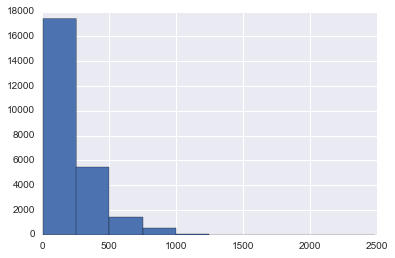

In [26]:
plt.hist(review_len)

### Processing 10 words of review as a single word to reduce word count

In [27]:
vocab = set(vec.index2word)
def getWordVectorTimeSeries(review_list):
    T = 50
    D = 32
    x_vec = np.zeros((T,D))
    i = 0
    for review in review_list:
        if (i<500) and (review in vocab):
            x_vec[i//10] += vec[review]
            i += 1
    return x_vec

In [28]:
N = len(trainReview)
T = 50
D = 32
X_train = np.zeros((N, T, D))
for i in xrange(N):
    X_train[i] = getWordVectorTimeSeries(trainReview[i])

In [29]:
X_train.shape

(25000, 50, 32)

In [30]:
N = len(testReview)
X_test = np.zeros((N, T, D))
for i in xrange(N):
    X_test[i] = getWordVectorTimeSeries(testReview[i])   

In [31]:
X_train = X_train.reshape((-1,1,50,32))
X_test = X_test.reshape((-1,1,50,32))
y_train = pd.get_dummies(train.sentiment).values

### CNN using Keras

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam

model = Sequential()

model.add(Convolution2D(32, 3, 32, border_mode='valid', input_shape=(1, 50, 32)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 1)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 1)))
model.add(Dropout(0.25))
model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

adam = Adam(lr=0.002)
model.compile(loss='binary_crossentropy', optimizer='adam')


In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 48, 1)     3104        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 48, 1)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 1)     0           activation_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 16, 1)     0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [42]:
from sklearn.cross_validation import train_test_split
X1,X2,y1,y2 = train_test_split(X_train, y_train, test_size=0.3)

In [43]:
model.fit(X1, y1, batch_size=32, nb_epoch=5)

Epoch 1/5
17500/17500 [==============================] - 6s - loss: 0.5452     
Epoch 2/5
17500/17500 [==============================] - 6s - loss: 0.4253     
Epoch 3/5
17500/17500 [==============================] - 6s - loss: 0.4024     
Epoch 4/5
17500/17500 [==============================] - 6s - loss: 0.3867     
Epoch 5/5
17500/17500 [==============================] - 6s - loss: 0.3826     


In [44]:
model.evaluate(X2, y2, batch_size=16)

7456/7500 [============================>.] - ETA: 0s

0.35628810224533081

In [48]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=10)

Epoch 1/10
25000/25000 [==============================] - 8s - loss: 0.3244     
Epoch 2/10
25000/25000 [==============================] - 8s - loss: 0.3233     
Epoch 3/10
25000/25000 [==============================] - 8s - loss: 0.3193     
Epoch 4/10
25000/25000 [==============================] - 8s - loss: 0.3212     
Epoch 5/10
25000/25000 [==============================] - 8s - loss: 0.3212     
Epoch 6/10
25000/25000 [==============================] - 8s - loss: 0.3175     
Epoch 7/10
25000/25000 [==============================] - 8s - loss: 0.3187     
Epoch 8/10
25000/25000 [==============================] - 8s - loss: 0.3160     
Epoch 9/10
25000/25000 [==============================] - 8s - loss: 0.3194     
Epoch 10/10
25000/25000 [==============================] - 9s - loss: 0.3144     


In [49]:
result = model.predict(X_test)

In [52]:
result[0]

array([  7.69280887e-04,   9.99230742e-01], dtype=float32)

In [53]:
result = np.argmax(result, axis=1)

In [54]:
output = pd.DataFrame(data={"id":test["id"],"sentiment":result})

In [55]:
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",0
4,"""12128_7""",1


In [56]:
output.to_csv("Word2VecCNN.csv",index=False,quoting=3)

Got 0.84672 on Kaggle